In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import random
from scipy.stats import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import *
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import hashlib

from matplotlib import pyplot as plt
# from datasketch import MinHash, Simhash
import utils

import warnings
warnings.filterwarnings('ignore')

c:\Users\pywong\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The cosine similarity of the document characteristic matrix has a positive correlation to the Jaccard similarity of the signature matrix.

In [2]:
# pick a target document to compare
target_doc_num = 0

# input feature size (number of token used)
feature_size = 2**12
random.seed(10)

# input folder
data_root = os.path.join(os.getcwd(),'input')

In [3]:
df = utils.load_data_from_local(data_root)

Meta data size: 9022
c:\Users\pywong\Desktop\PolyU\COMP5434 Big Data Computing\Assignment\COMP5434-Big-Data-Computing\input\subset\subset\document_parses\pdf_json
total json files: 12000


100%|██████████| 8083/8083 [00:26<00:00, 300.58it/s]
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pywong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Define characteristic matrix by tokenizing the processed text

In [4]:
# Build feature with token count
count_vectorizer = CountVectorizer(max_features=feature_size)
X_count = count_vectorizer.fit_transform(df['processed_text'].values).toarray().T

# Clip count between 0 and 1 to only consider the token exists in document or not
X_clip = np.clip(X_count, 0, 1)

# USe TF-IDF as feature
tfidf_vectorizer = TfidfVectorizer(max_features=feature_size)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'].values).toarray().T

In [89]:
count_result = check_document_similarity(X_count,df,target_doc_num)
clip_result = check_document_similarity(X_clip,df,target_doc_num)
tfidf_result = check_document_similarity(X_tfidf,df,target_doc_num)

In [5]:
def check_document_similarity(X,df,target_doc_num):
    '''
    Given the target document number, return the similarity to other documents.
    Output is a pandas dataframe with number of document as number of row.
    '''
    
    target_doc = X.T[target_doc_num]
    target_doc_norm = np.linalg.norm(target_doc)
    
    doc_l2_norm_list = []
    doc_l1_norm_list = []
    doc_cosine_list = []
    
    # Similarity from characteristic matrix X
    # X is 4096(feature) x 8041(document)
    
    for doc in X.T:
        doc_norm = np.linalg.norm(doc)
        doc_l2_norm = np.linalg.norm(target_doc - doc)
        doc_l1_norm = np.linalg.norm(target_doc - doc,ord=1)
        doc_cosine = doc@target_doc.T/(doc_norm*target_doc_norm)

        doc_l2_norm_list.append(doc_l2_norm)
        doc_l1_norm_list.append(doc_l1_norm)
        doc_cosine_list.append(doc_cosine)

    
    result = pd.DataFrame(
        {
            'doc_l1_norm':doc_l1_norm_list,
            'doc_l2_norm':doc_l2_norm_list,
            'doc_cosine_similarity':doc_cosine_list,
            # 'sig_cosine_similarity':sig_cosine_list,
            # 'sig_jaccard_similarity':sig_jaccard_list
        }
    )
    
    result = result.reset_index().rename(columns={'index':'doc_num'})
    result = pd.concat([result,df[['paper_id','body_text']]],axis=1)
    
    return result


# def get_result_rank(df):
    
#     for col in df.columns:
#         if col not in ['doc_num']:
#             df[f'{col}_rank'] = df[col].rank()
        
#     df = df.dropna()
    
#     return df



MinHash

Using token occurrence as document feature. Create a signature matrix using MinHash.
Compare the signature Jaccard similarity with the document L1 Norm (Hamming distance).

In [6]:
def get_permutate_matrix(X,num_hash=50):
    
    '''
    Return premutation matrix with size:
    number of feature x number of permutation
    '''
    
    N = len(X) # number of features

    p = []

    for i in range(0,num_hash):
        a = random.randint(0, N-1)
        b = random.randint(0, N-1)
        
        new_order = np.array([])
        not_used = list(range(1,N+1))
        
        for j in range(0,N):
            # Buckets are set to be 1 to N
            hash_value = (a*j+b)%N+1
            
            # When 2 hashes mapped to the same bucket, the second hash move to the next bucket.
            while hash_value not in not_used:
                hash_value += 1
                if hash_value > N:
                    hash_value = 1

            not_used.remove(hash_value)
            new_order = np.append(new_order,hash_value)
              
        p.append(new_order)
        
    p = np.array(p).T
    
    return p

def get_minhash_signature(X,p):
    '''
    Return signature matrix with size: number of permutation x number of document
    '''

    s = []
    
    # X is 4096(feature) x 8041(document)
    # p is 4096(feature) x 50 (permutation)
    # Create a signature matrix with size as number of permutation x number of document

    for perm in p.T:
        doc_sig = np.array([])
        for doc in X.T:
            sig_set = set(np.multiply(doc,perm))
            sig_set.discard(0)
            sig = min(sig_set)
            doc_sig = np.append(doc_sig,sig)
            
        s.append(doc_sig)

    s = np.array(s)
    
    return s

def check_minhash_similarity(s,target_doc_num):

    sig_jaccard_list = []
    sig_cosine_list = []
    
    # Similarity from signature matrix
    # s is 50(permutation) x 8041(document)
    
    target_sig = s.T[target_doc_num]
    target_sig_norm = np.linalg.norm(target_sig)
    
    # loop through all document to create a list of score
    for sig in s.T:
        sig_norm = np.linalg.norm(sig)
        sig_cosine = (sig @ target_sig.T)/(sig_norm*target_sig_norm)
        sig_cosine_list.append(sig_cosine)

        sig_intersection = len(list(set(target_sig).intersection(sig)))
        sig_union = (len(set(target_sig)) + len(set(sig))) - sig_intersection
        sig_jaccard = sig_intersection / sig_union
        sig_jaccard_list.append(sig_jaccard)   
        
    df = pd.DataFrame(
        {
            'sig_cosine_similarity':sig_cosine_list,
            'sig_jaccard_similarity':sig_jaccard_list
        }
    )
    
    df = df.reset_index().rename(columns={'index':'doc_num'})
    
    return df



In [7]:
p = get_permutate_matrix(X_clip)
s = get_minhash_signature(X_clip,p)
s

array([[ 4.,  3.,  4., ...,  3.,  4.,  3.],
       [ 1.,  1.,  1., ...,  1.,  8.,  1.],
       [ 6.,  7.,  4., ...,  4.,  6.,  2.],
       ...,
       [ 3., 13.,  8., ...,  8.,  8.,  3.],
       [ 3.,  5.,  5., ...,  5.,  5.,  5.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.]])

In [8]:
# Check Performance
clip_result = check_document_similarity(X_clip,df,target_doc_num)
minhash_result = check_minhash_similarity(s,target_doc_num)	

minhash_result = clip_result.merge(minhash_result,how='outer',on='doc_num')
minhash_result = minhash_result.sort_values(by=['sig_jaccard_similarity'],ascending=False)
# minhash_result = get_result_rank(minhash_result)
minhash_result.head(11)


,doc_num,doc_l1_norm,doc_l2_norm,doc_cosine_similarity,paper_id,body_text,sig_cosine_similarity,sig_jaccard_similarity
0,0,0.0,0.000000,1.000000,0015cecc2298c3bdb9bda0e0b84b38ebdcca716f,Systemic inflammation is the hallmark of coron...,1.000000,1.000000
3814,3814,893.0,29.883106,0.310127,78d85536384dd8b640682087a0e35949de4102a0,G ender disparities persist across the HIV car...,0.724273,1.000000
2475,2475,963.0,31.032241,0.338548,4f1d25e6f849a7704399ff66b84618299c62706a,"Mechanochemistry, as a method of synthesis tha...",0.715556,0.882353
6278,6278,844.0,29.051678,0.373106,c937b1ef6e9949487c8b94ea7d9e9e3d90ce5ab9,"Hypophosphatasia (HPP) is a rare, systemic, in...",0.672958,0.882353
724,724,871.0,29.512709,0.321102,192656848cc27410fabadab04a03e5ac42277945,The global coronavirus disease 2019 (COVID-19)...,0.694762,0.882353
5352,5352,875.0,29.580399,0.296901,a9fd1eaa7f89fc7d3f02d5ba17daa304e0e2b9d5,Donati et al. [1] assumed that 28% of the mate...,0.671465,0.882353
4801,4801,980.0,31.304952,0.298005,981bf395b1dcf8d5c09673e9a28f51d363d81d06,"The global pandemic of COVID-19, rst identi ed...",0.743263,0.882353
4367,4367,943.0,30.708305,0.367604,8a8fe7d983b344085df73c8ab2ead96cf6187e1f,The Coronavirus disease 2019 (COVID-19) [1] wa...,0.779164,0.882353
6155,6155,917.0,30.282008,0.371979,c540d7c08bf13f8d4dc41f5ea27df27e04c57d9c,The wellbeing of caregivers/teachers is partic...,0.617519,0.882353
1657,1657,893.0,29.883106,0.370796,36a8d9aff8433686752025c8699d5a5ffc6e9ceb,"In recent years, emerging infectious septicemi...",0.615754,0.882353


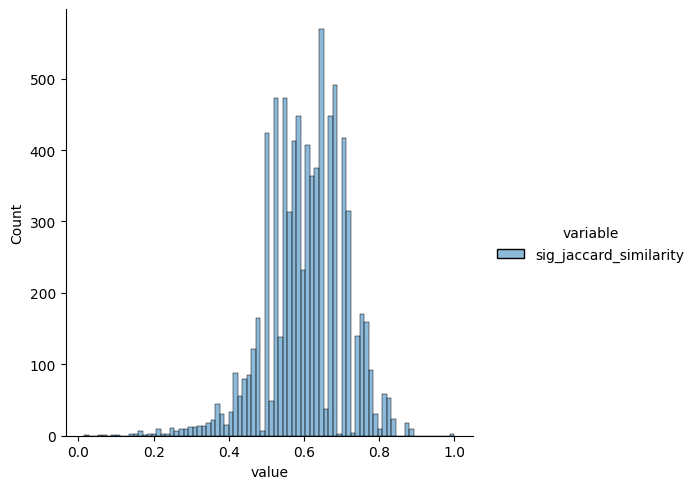

In [9]:
plot_df = minhash_result[['sig_jaccard_similarity']].melt()
sns.displot(plot_df, x='value', hue='variable')

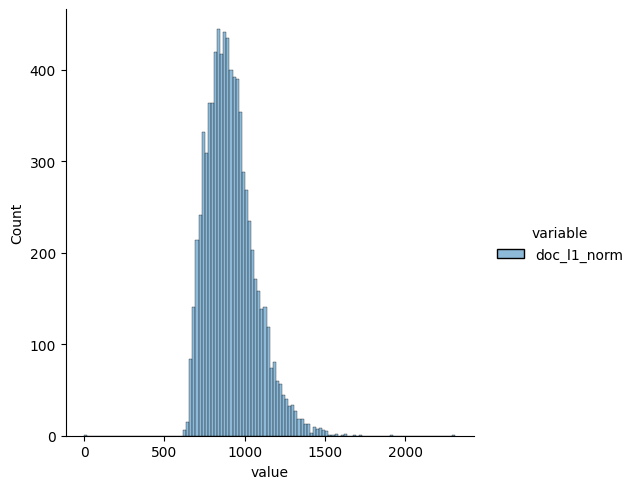

In [10]:
plot_df = minhash_result[['doc_l1_norm']].melt()
sns.displot(plot_df, x='value', hue='variable')

Distribution of document L1 norm (Hamming distance for token occurrence as feature). 
The figure shows that the distribution is skewed toward a lower L1 distance. Since the L1 norm is porportional to the number of token, the figure implies most of other documents have a similar number of tokens as the target document. 

PearsonRResult(statistic=0.12572229189937273, pvalue=1.0823588952121561e-29)


<Axes: xlabel='doc_cosine_similarity'>

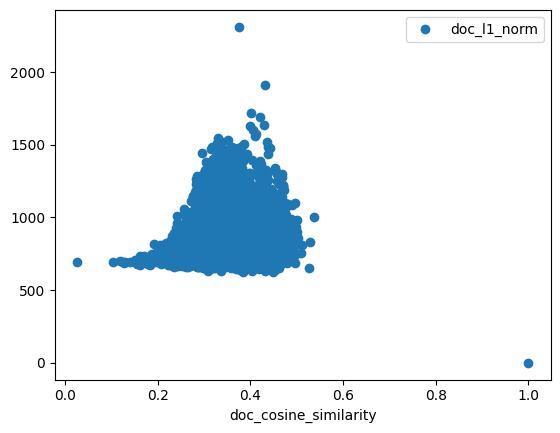

In [11]:
print(pearsonr(minhash_result['doc_cosine_similarity'],minhash_result['doc_l1_norm']))
minhash_result.plot(x='doc_cosine_similarity', y='doc_l1_norm', style='o')

PearsonRResult(statistic=0.16113215171049683, pvalue=6.578957750169202e-48)


<Axes: xlabel='sig_jaccard_similarity'>

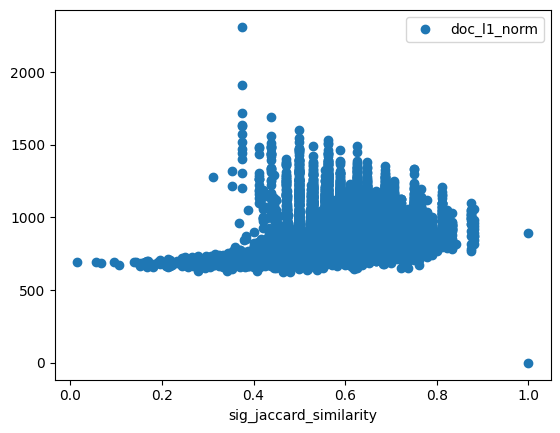

In [12]:
print(pearsonr(minhash_result['sig_jaccard_similarity'],minhash_result['doc_l1_norm']))
minhash_result.plot(x='sig_jaccard_similarity', y='doc_l1_norm', style='o')

This figure shows that the Jaccard similarity is high when the document L1 norm is low when excluding the cases with L1 norm below 750. The low L1 norm region is because most of the document has a similar number of token used compare to the target document.

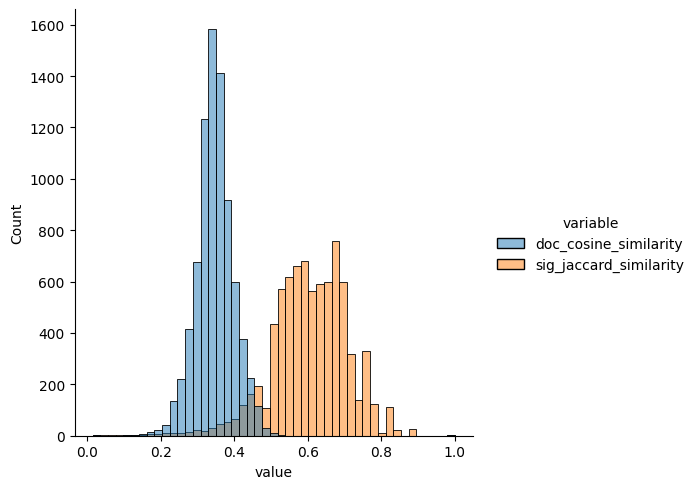

In [13]:
plot_df = minhash_result[['doc_cosine_similarity','sig_jaccard_similarity']].melt()
sns.displot(plot_df, x='value', hue='variable')

The Jaccard similarity of the signature has a similar distribution with the cosine similarity of the document but with a higher mean and variance. This is because the characteristic matrix is a sprase matrix with only 0 or 1 which makes the dot product between documents are likely to be small. Meanwhile, the signature matrix uses 50 different hash function for permutation. This cause the increase in variance for the Jaccard similarity in the signature matrix.

PearsonRResult(statistic=0.2646217009383495, pvalue=6.265243162596155e-129)


<Axes: xlabel='doc_cosine_similarity'>

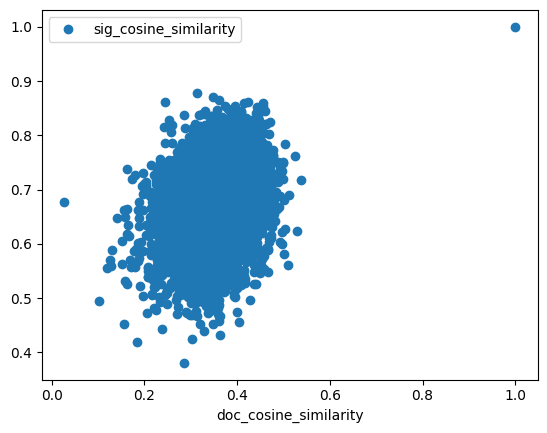

In [14]:
print(pearsonr(minhash_result['doc_cosine_similarity'],minhash_result['sig_cosine_similarity']))
minhash_result.plot(x='doc_cosine_similarity', y='sig_cosine_similarity', style='o')

The cosine similarity of document has low correlation with the cosine similarity of signature.

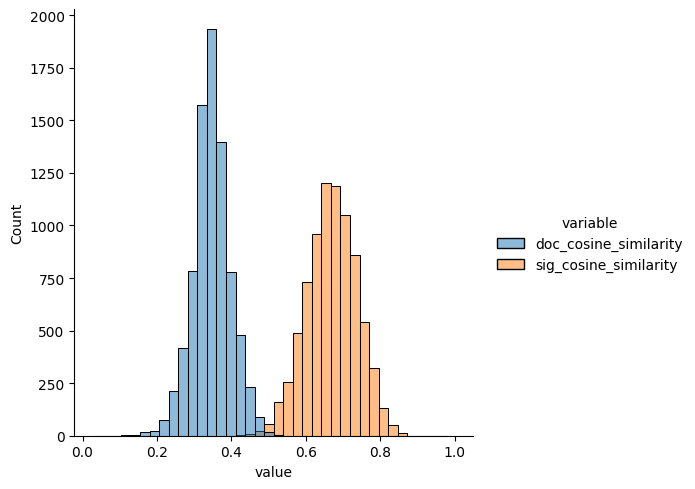

In [15]:
plot_df = minhash_result[['doc_cosine_similarity','sig_cosine_similarity']].melt()
sns.displot(plot_df, x='value', hue='variable')

The document characteristic matrix and the signature matrix has a similar distribution with a mean shift.
This means the signature stastically preserve the feature distribution in documents.

SimHash

Using TF-IDF as document feature. Create a signature matrix using SimHash.
Compare the signature Hamming distance with the document cosine similarity.

In [81]:

def get_feature_hash(feature_list):
        
    feature_hash = []
    
    for feature_name in feature_list:        
        # Use MD5 or SHA1 to encode, since these hash functions are localicity sensitive
        # Convert the integer into string of 0 or 1 as a hash.
        
        encod_feature = str.encode(feature_name)
        
        # MD5
        feature_byte = hashlib.md5(encod_feature).digest()
        feature_int = int.from_bytes(feature_byte, byteorder='big').bit_length()
        feature_bit = f'{feature_int:064b}'.zfill(64)
        
        # SHA1
        # feature_byte = hashlib.sha1(encod_feature).hexdigest()
        # feature_int = int(feature_byte, 16)
        # feature_bit = f'{feature_int:064b}'.zfill(64)
        
        
        feature_hash.append(feature_bit)
        
    return feature_hash

    
def get_finger_print_list(X,feature_hash):
    finger_print_list = []
    
    for doc in X.T:
        feature_used = []
        
        # Only add the feature into the finger print if the TF-IDF score is greater than 0.
        # Skip for tokens that are not in the document or exists in every document.
        for i in range(0,len(doc)):
            if doc[i] > 0:
                feature = feature_hash[i]
                feature_used.append(feature)
        
        if len(feature_used) == 0:
            continue
        
        # Combine all used feature into one finger print for each document
        finger_print_matrix = []
        
        for feature in feature_used:
            feature_bit = []
            for bit in feature:
                feature_bit.append(int(bit)) # 0 or 1
        
            finger_print_matrix.append(feature_bit)
        
        # Finger print matrix has size as number of feature (max 4096) x number of bit (64)
        finger_print_matrix = np.array(finger_print_matrix)
        finger_print = finger_print_matrix.mean(axis=0)

        # If the majority of the feature has the same bit in some position,
        # assign the finger print position with the same bit.   
        for i in range(0,len(finger_print)):
            value = finger_print[i]
            if value > 0.5:
                finger_print[i] = 1
            elif value < 0.5:
                finger_print[i] = 0
                
            # When the ratio is 0.5, use the bit position to determine 
            else:
                finger_print[i] = i%2

        finger_print_list.append(finger_print)   
                
    return finger_print_list
                

def check_simhash_similarity(finger_print_list,target_doc_num):
    
    sig_cosine_list = []
    sig_hamming_distance_list = []
    
    target_sig = finger_print_list[target_doc_num]
    target_sig_norm = np.linalg.norm(target_sig)
    
    for sig in finger_print_list:
        sig_norm = np.linalg.norm(sig)
        sig_cosine = (sig @ target_sig.T)/(sig_norm*target_sig_norm)
        sig_cosine_list.append(sig_cosine)
        
        # Distance is the number of different bit
        sig_hamming_distance = np.sum(sig != target_sig)
        sig_hamming_distance_list.append(sig_hamming_distance)
    
    df = pd.DataFrame(
        {
            'sig_cosine_similarity':sig_cosine_list,
            'sig_hamming_distance':sig_hamming_distance_list
        }
    )
    
    df = df.reset_index().rename(columns={'index':'doc_num'})
    
    return df


In [82]:
tfidf_feature_list = list(tfidf_vectorizer.get_feature_names_out())
feature_hash = get_feature_hash(tfidf_feature_list)
finger_print_list = get_finger_print_list(X_tfidf,feature_hash)

In [83]:
# Check Performance
tfidf_result = check_document_similarity(X_tfidf,df,target_doc_num)
simhash_result = check_simhash_similarity(finger_print_list,target_doc_num)

simhash_result = tfidf_result.merge(simhash_result,how='outer',on='doc_num')
simhash_result = simhash_result.sort_values(by=['sig_hamming_distance'],ascending=True)
# minhash_result = get_result_rank(minhash_result)
simhash_result.head(11)

,doc_num,doc_l1_norm,doc_l2_norm,doc_cosine_similarity,paper_id,body_text,sig_cosine_similarity,sig_hamming_distance
0,0,0.000000,0.000000,1.000000,0015cecc2298c3bdb9bda0e0b84b38ebdcca716f,Systemic inflammation is the hallmark of coron...,1.0,0
5202,5202,17.385425,0.847847,0.640578,a47b0b4044d87473435e5d47e738dc98a15de253,Pain severely afflicts almost half a billion p...,1.0,0
5200,5200,16.958739,0.886608,0.606963,a460af0d1f63dcf5465a2ac2b4b1905beadc36ca,Several social health insurance markets includ...,1.0,0
5199,5199,18.288292,1.069602,0.427976,a45dfd6f07cfe6d75b1f15832ceed59af31d726b,Although the rate of cigarette smoking among a...,1.0,0
5198,5198,18.186716,1.114785,0.378628,a45ddcc047883b3a3843797811ff7cb6c173b8e9,. The quality of online information about peri...,1.0,0
5197,5197,16.962810,0.832505,0.653467,a454eac124326fc1cf308234f5966e4d9874b05c,Rabdosia genus is an important genus of the La...,1.0,0
5195,5195,19.104106,0.904220,0.591193,a44c9f5e249cabeef88fca9d82ec5db7f3ba1f26,The United Nations General Assembly in Septemb...,1.0,0
5194,5194,17.857407,1.024958,0.474730,a44a918459a779ef4dfddcdf56640df86d0c2ae0,Alveolar macrophages (AM) are the sentinel pha...,1.0,0
5193,5193,20.071024,0.980964,0.518855,a445c3a9019cb4110d8c53610dae0b7f79fe0587,a1111111111 a1111111111 a1111111111 a111111111...,1.0,0
5192,5192,19.587837,0.920910,0.575962,a438e8a94ad51f30132a3fec46105f9cef60ad45,P andemics created by novel viruses from anima...,1.0,0


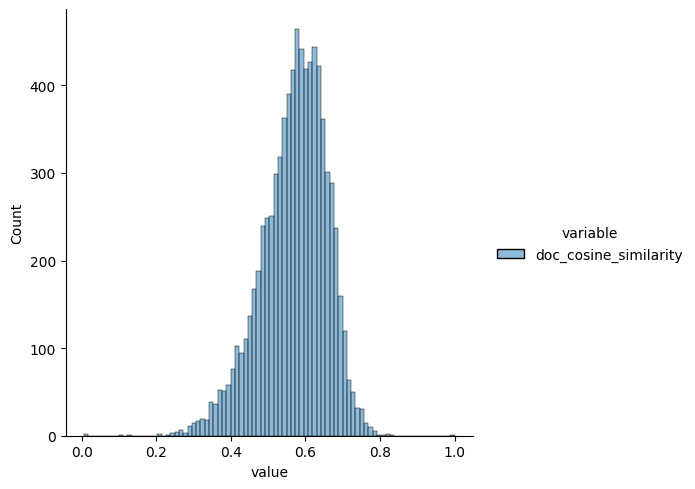

In [84]:
plot_df = simhash_result[['doc_cosine_similarity']].melt()
sns.displot(plot_df, x='value', hue='variable')

The document cosine similarity is slightly skewed toword the right hand side. This means the doocuments are more likely to be different from the traget document.

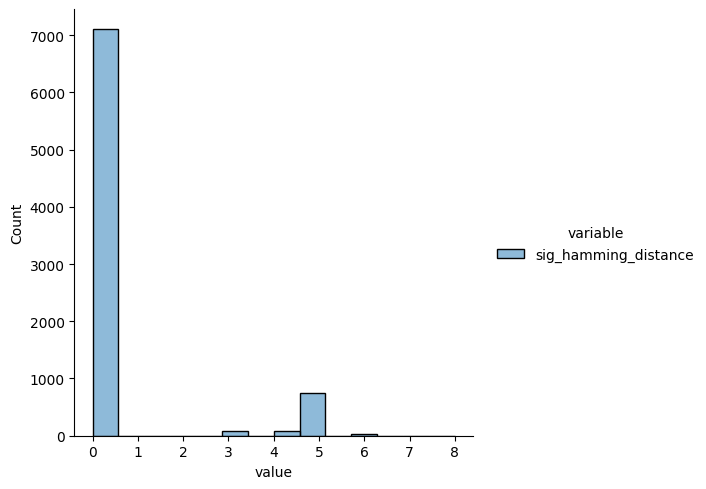

In [85]:
plot_df = simhash_result[['sig_hamming_distance']].melt()
sns.displot(plot_df, x='value', hue='variable')

PearsonRResult(statistic=0.011875231587999548, pvalue=0.2869921179041192)


<Axes: xlabel='doc_l2_norm'>

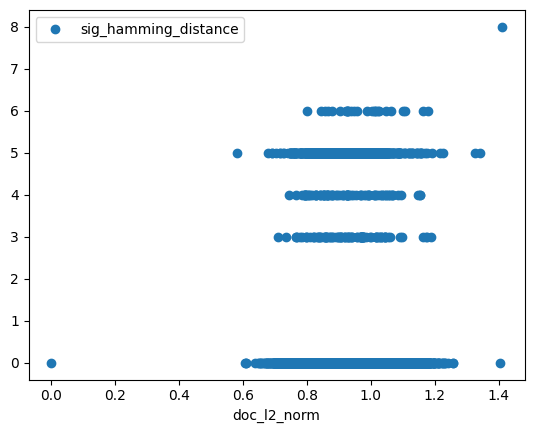

In [86]:
print(pearsonr(simhash_result['doc_l2_norm'],simhash_result['sig_hamming_distance']))
simhash_result.plot(x='doc_l2_norm', y='sig_hamming_distance', style='o')

PearsonRResult(statistic=-0.013309972802419967, pvalue=0.2327150364740963)


<Axes: xlabel='doc_cosine_similarity'>

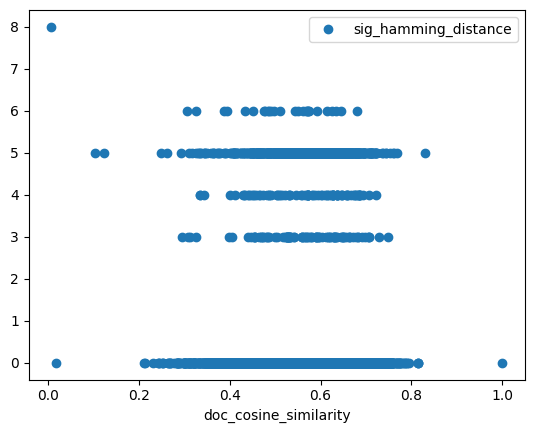

In [87]:
print(pearsonr(simhash_result['doc_cosine_similarity'],simhash_result['sig_hamming_distance']))
simhash_result.plot(x='doc_cosine_similarity', y='sig_hamming_distance', style='o')

In [88]:
stop

NameError: name 'stop' is not defined

The signature Hamming distance has a negative correlation with the document cosine similarity.

Doc2Vec

Word2Vec also need to consider token position for word embeding. Use the original text instead of the processed text for vectorization.

In [ ]:
# Use pretrained model to tokenize the documents.
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def tag_documents(orginal_docs):
    tagged_docs = []
    for i in range(0,len(orginal_docs)):
        doc = orginal_docs[i]
        doc_id = str(i)
        tokens = tokenizer.tokenize(doc)
        tagged_doc = TaggedDocument(words=tokens,tags=[doc_id])
        tagged_docs.append(tagged_doc)
        
    return tagged_docs


def get_doc2vec_result(model,original_docs,target_doc_num):
    
    target_doc = original_docs[target_doc_num]
    target_tokens = tokenizer.tokenize(target_doc)
    inferred_vector = model.infer_vector(target_tokens)
    similar_docs = model.dv.most_similar([inferred_vector],topn=len(original_docs))
    
        
    doc_num_list = []
    rank_list = []

    for i in range(0,len(similar_docs)):
        doc = similar_docs[i]
        rank = i + 1 # rank start from 1 instead of 0, 1 has highest similarity
        doc_num = int(doc[0])
        
        rank_list.append(rank)
        doc_num_list.append(doc_num)
        
    doc2vec_result = pd.DataFrame({'doc2vec':rank_list,'doc_num':doc_num_list})
    
    return doc2vec_result

In [ ]:
original_docs = list(df['body_text'])
tagged_docs = tag_documents(original_docs)

Token indices sequence length is longer than the specified maximum sequence length for this model (4439 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
model = Doc2Vec()
model.build_vocab(tagged_docs)
model.train(tagged_docs,total_examples=model.corpus_count,epochs=20)

In [ ]:
doc2vec_result = get_doc2vec_result(model,original_docs,target_doc_num)
doc2vec_result

,doc2vec_rank,doc_num
0,1,0
1,2,3516
2,3,2211
3,4,3155
4,5,1654
...,...,...
8036,8037,3257
8037,8038,378
8038,8039,5184
8039,8040,1945


Comparing the performance of different document similarity search methods with the cosine similarity of document with TF-IDF word embeding.


In [ ]:
#
# Similar item has the lowest rank
tfidf_rank = tfidf_result[['doc_num','doc_cosine_similarity','doc_l1_norm','doc_l2_norm']]
tfidf_rank['tfidf_doc_cosine'] = tfidf_rank['doc_cosine_similarity'].rank(ascending=False)
tfidf_rank['tfidf_doc_l1_norm'] = tfidf_rank['doc_l1_norm'].rank(ascending=True)
tfidf_rank['tfidf_doc_l2_norm'] = tfidf_rank['doc_l2_norm'].rank(ascending=True)
tfidf_rank = tfidf_rank[['doc_num','tfidf_doc_cosine','tfidf_doc_l1_norm','tfidf_doc_l2_norm']]

count_rank = count_result[['doc_num','doc_cosine_similarity','doc_l1_norm','doc_l2_norm']]
count_rank['count_doc_cosine'] = count_rank['doc_cosine_similarity'].rank(ascending=False)
count_rank['count_doc_l1_norm'] = count_rank['doc_l1_norm'].rank(ascending=True)
count_rank['count_doc_l2_norm'] = count_rank['doc_l2_norm'].rank(ascending=True)
count_rank = count_rank[['doc_num','count_doc_cosine','count_doc_l1_norm','count_doc_l2_norm']]



clip_rank = clip_result[['doc_num','doc_cosine_similarity','doc_l1_norm','doc_l2_norm']]
clip_rank['clip_doc_cosine'] = clip_rank['doc_cosine_similarity'].rank(ascending=False)
clip_rank['clip_doc_l1_norm'] = clip_rank['doc_l1_norm'].rank(ascending=True)
clip_rank['clip_doc_l2_norm'] = clip_rank['doc_l2_norm'].rank(ascending=True)
clip_rank = clip_rank[['doc_num','clip_doc_cosine','clip_doc_l1_norm','clip_doc_l2_norm']]

minhash_rank = minhash_result[['doc_num','sig_cosine_similarity','sig_jaccard_similarity']]
minhash_rank['minhash_cosine'] = minhash_rank['sig_cosine_similarity'].rank(ascending=False)
minhash_rank['minhash_jaccard'] = minhash_rank['sig_cosine_similarity'].rank(ascending=False)
minhash_rank = minhash_rank[['doc_num','minhash_cosine','minhash_jaccard']]

simhash_rank = simhash_result[['doc_num','sig_cosine_similarity','sig_hamming_distance']]
simhash_rank['simhash_cosine'] = simhash_rank['sig_cosine_similarity'].rank(ascending=False)
simhash_rank['simhash_hamming'] = simhash_rank['sig_hamming_distance'].rank(ascending=True)
simhash_rank = simhash_rank[['doc_num','simhash_cosine','simhash_hamming']]

NameError: name 'check_result_similarity' is not defined